# Hypertuning and Regularization for our simple base model

In [2]:
import json

with open('train_.txt') as json_file:  
    train_data = json.load(json_file)

from random import shuffle
shuffle(train_data)



a=[]
for i in train_data:
    a.append(i['category'])
classes=set(a)

classes

{'BLACK VOICES', 'COMEDY', 'HEALTHY LIVING', 'SPORTS', 'WORLD NEWS'}

In [5]:
train_data=train_data[0:1000]
len(train_data)

1000

In [7]:
import pandas as pd

d = {}
for k,v in enumerate(classes):
    d[v] = k
    
k=[]
C=[]
for item in train_data:
    c=d[item['category']]
    C.append(c)
    EXP=item['headline']+item['short_description']
    k.append(EXP)

train_df = pd.DataFrame(k)
train_df['category']=C
train_df.columns=["sentence","category"]

In [8]:
train_df.head()

,sentence,category
0,It's Totally Normal That Your Sex Life Is Noth...,1
1,Lamar Odom's Speech Is Improving During Therap...,4
2,"After The Floods, Zimbabwean Women Are Impatie...",3
3,Opioid Prescriptions Are Declining -- But Not ...,1
4,The Source Of Donald Trump's Military Expertis...,2


In [19]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import pandas as pd
import re
import keras.layers as layers

from collections import Counter
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Input, Embedding, BatchNormalization, LSTM, Dense, Concatenate , Dropout
from keras.models import Model

from keras.utils import plot_model

In [10]:
time_steps = 100

# building vocabulary from dataset
def build_vocabulary(sentence_list):
    unique_words = " ".join(sentence_list).strip().split()
    word_count = Counter(unique_words).most_common()
    vocabulary = {}
    for word, _ in word_count:
        vocabulary[word] = len(vocabulary)        

    return vocabulary

vocabulary = build_vocabulary(train_df["sentence"])

In [12]:
inputs = Input(shape=(500, ))
embedding_layer = Embedding(len(vocabulary),
                            16,input_length=500)(inputs)
word_embedding= BatchNormalization()(embedding_layer)

x = LSTM(128)(word_embedding)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 16)           156288    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500, 16)           64        
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               74240     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 165       
Total para

In [13]:
# Create datasets (Only take up to time_steps words for memory)
train_text = train_df['sentence'].tolist()
train_text = [' '.join(t.split()[0:time_steps]) for t in train_text]
train_text = np.array(train_text)
train_label = np.array(train_df['category'].tolist())

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_LENGTH = 500
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)
post_seq = tokenizer.texts_to_sequences(train_text)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, train_label, test_size=0.05)

In [24]:
from keras.utils import to_categorical

history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=False, epochs=5)

Train on 712 samples, validate on 238 samples
Epoch 1/5
712/712 [==============================] - 39s 55ms/step - loss: 0.3271 - acc: 0.9185 - val_loss: 1.7837 - val_acc: 0.4958
Epoch 2/5
712/712 [==============================] - 40s 56ms/step - loss: 0.1966 - acc: 0.9551 - val_loss: 1.8521 - val_acc: 0.5420
Epoch 3/5
712/712 [==============================] - 41s 57ms/step - loss: 0.0969 - acc: 0.9761 - val_loss: 2.1993 - val_acc: 0.4790
Epoch 4/5
712/712 [==============================] - 39s 55ms/step - loss: 0.0558 - acc: 0.9916 - val_loss: 2.2396 - val_acc: 0.5084
Epoch 5/5
712/712 [==============================] - 28s 39ms/step - loss: 0.0437 - acc: 0.9874 - val_loss: 2.0404 - val_acc: 0.4958


In [25]:
model.evaluate(X_test,to_categorical(y_test))

50/50 [==============================] - 0s 3ms/step


[1.8034790754318237, 0.5200000095367432]

### - In this notebook I am just trying to decrease overfitting in my simple model and for that aim I made several experiments and I decreased my sample to 1000.
### - At the above we can see my base model there is huge overfitting like almost %50 

## Adding Dropout Layer

In [30]:
import copy
result = {}
y = {}
loss = []
acc = []
dropouts = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for dropout in dropouts:
    print ("Dropout: ", dropout)

    inputs = Input(shape=(500, ))
    embedding_layer = Embedding(len(vocabulary),
                            16,input_length=500)(inputs)
    word_embedding= BatchNormalization()(embedding_layer)

    x = LSTM(128)(word_embedding)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=[inputs], outputs=predictions)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
    model_simple = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=False, epochs=5)
    score = model.evaluate(X_test, to_categorical(y_test),verbose=0)
    y[dropout] = model.predict(X_test)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    result[dropout] = copy.deepcopy(model_simple.history)   
    loss.append(score[0])
    acc.append(score[1])

Dropout:  0.0
Train on 712 samples, validate on 238 samples
Epoch 1/5
712/712 [==============================] - 26s 36ms/step - loss: 1.5696 - acc: 0.2584 - val_loss: 1.5580 - val_acc: 0.2689
Epoch 2/5
712/712 [==============================] - 24s 33ms/step - loss: 1.5300 - acc: 0.2935 - val_loss: 1.5498 - val_acc: 0.2647
Epoch 3/5
712/712 [==============================] - 24s 33ms/step - loss: 1.4263 - acc: 0.3525 - val_loss: 1.5387 - val_acc: 0.3151
Epoch 4/5
712/712 [==============================] - 24s 34ms/step - loss: 1.0389 - acc: 0.6180 - val_loss: 1.5756 - val_acc: 0.4286
Epoch 5/5
712/712 [==============================] - 25s 35ms/step - loss: 0.6568 - acc: 0.7893 - val_loss: 1.5183 - val_acc: 0.4286
Test score: 1.7466796016693116
Test accuracy: 0.28000000476837156
Dropout:  0.1
Train on 712 samples, validate on 238 samples
Epoch 1/5
712/712 [==============================] - 31s 43ms/step - loss: 1.6114 - acc: 0.1854 - val_loss: 1.5816 - val_acc: 0.2689
Epoch 2/5
712/71

### As we can see dropout with rate 0.2 helped us do decrease overfitting to %32

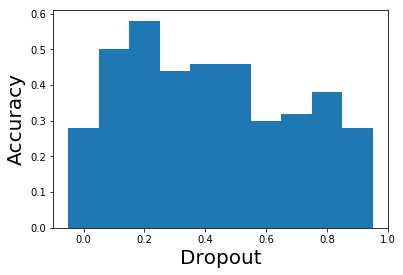

In [37]:
import numpy as np                                                               
import matplotlib.pyplot as plt

width = 0.1

plt.bar(dropouts, acc, width, align='center')
#plt.figure(figsize=(50,50))
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)

plt.ylabel('Accuracy',size = 20)
plt.xlabel('Dropout', size = 20)
plt.show()

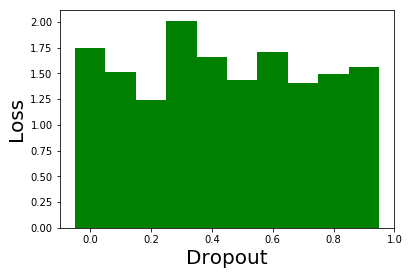

In [38]:
width = 0.1

plt.bar(dropouts, loss, width, align='center',color = 'green')

plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)

plt.ylabel('Loss',size = 20)
plt.xlabel('Dropout', size = 20)
plt.show()

### From this experiment we can say that Dropout layer with rate 0.2 is best suitable for our model and it helped to increase the accuracy score

## Fine Tune Hyper-Parameters

In [46]:
from keras import optimizers

result = {}
y = {}
loss = []
acc = []

learning_rates = [0.1,0.01,0.001,0.0001,0.00001]
lr_weight_decay = 0.95  

for lr in learning_rates:
    print ("Learning rate: ", lr)
    
    inputs = Input(shape=(500, ))
    embedding_layer = Embedding(len(vocabulary),
                            16,input_length=500)(inputs)
    word_embedding= BatchNormalization()(embedding_layer)

    x = LSTM(128)(word_embedding)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=[inputs], outputs=predictions)
    adam = optimizers.Adam(lr,decay=lr_weight_decay)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    model_simple = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=False, epochs=5)
    score = model.evaluate(X_test, to_categorical(y_test),verbose=0)
    y[lr] = model.predict(X_test)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    result[lr] = copy.deepcopy(model_simple.history)   
    loss.append(score[0])
    acc.append(score[1])

Learning rate:  0.1
Train on 712 samples, validate on 238 samples
Epoch 1/5
712/712 [==============================] - 173s 243ms/step - loss: 1.5910 - acc: 0.2303 - val_loss: 1.5694 - val_acc: 0.2689
Epoch 2/5
712/712 [==============================] - 118s 165ms/step - loss: 1.5541 - acc: 0.2935 - val_loss: 1.5636 - val_acc: 0.2689
Epoch 3/5
712/712 [==============================] - 71s 99ms/step - loss: 1.5118 - acc: 0.3020 - val_loss: 1.5545 - val_acc: 0.2689
Epoch 4/5
712/712 [==============================] - 67s 94ms/step - loss: 1.3683 - acc: 0.4705 - val_loss: 1.4672 - val_acc: 0.4160
Epoch 5/5
712/712 [==============================] - 68s 96ms/step - loss: 0.8690 - acc: 0.7346 - val_loss: 1.5652 - val_acc: 0.3697
Test score: 1.48705087184906
Test accuracy: 0.4200000023841858
Learning rate:  0.01
Train on 712 samples, validate on 238 samples
Epoch 1/5
712/712 [==============================] - 84s 117ms/step - loss: 1.5831 - acc: 0.2626 - val_loss: 1.5655 - val_acc: 0.2689
E

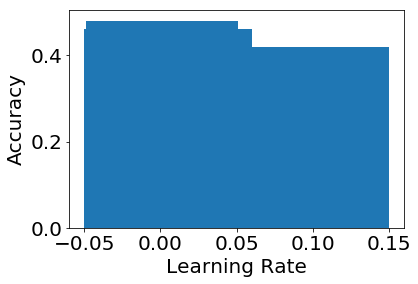

In [50]:
import numpy as np                                                               
import matplotlib.pyplot as plt

width = 0.1

plt.bar(learning_rates, acc, width, align='center')
#plt.figure(figsize=(50,50))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

plt.ylabel('Accuracy',size = 20)
plt.xlabel('Learning Rate', size = 20)
plt.show()

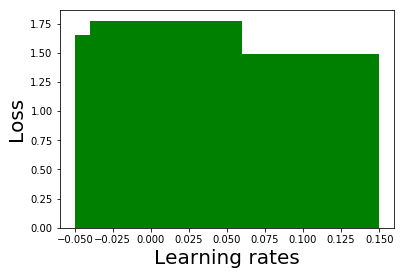

In [51]:
width = 0.1

plt.bar(learning_rates, loss, width, align='center',color = 'green')

plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)

plt.ylabel('Loss',size = 20)
plt.xlabel('Learning rates', size = 20)
plt.show()

## So also we can try different optimizer as RMSPROP

In [59]:
inputs = Input(shape=(500, ))
embedding_layer = Embedding(len(vocabulary),
                            16,input_length=500)(inputs)
word_embedding= BatchNormalization()(embedding_layer)

x = LSTM(128)(word_embedding)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
rmsprop = optimizers.RMSprop(lr=0.001, decay=0.95)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_48 (Embedding)     (None, 500, 16)           156288    
_________________________________________________________________
batch_normalization_48 (Batc (None, 500, 16)           64        
_________________________________________________________________
lstm_48 (LSTM)               (None, 128)               74240     
_________________________________________________________________
dense_139 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_45 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_140 (Dense)            (None, 32)                2080      
__________

In [60]:
model_simple = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=False, epochs=5)

Train on 712 samples, validate on 238 samples
Epoch 1/5
712/712 [==============================] - 91s 128ms/step - loss: 1.5840 - acc: 0.2528 - val_loss: 1.5803 - val_acc: 0.2521
Epoch 2/5
712/712 [==============================] - 79s 111ms/step - loss: 1.5245 - acc: 0.3020 - val_loss: 1.5623 - val_acc: 0.2773
Epoch 3/5
712/712 [==============================] - 88s 123ms/step - loss: 1.3856 - acc: 0.4382 - val_loss: 1.6502 - val_acc: 0.2815
Epoch 4/5
712/712 [==============================] - 91s 128ms/step - loss: 1.1803 - acc: 0.5829 - val_loss: 1.5603 - val_acc: 0.3950
Epoch 5/5
712/712 [==============================] - 90s 127ms/step - loss: 0.8247 - acc: 0.7233 - val_loss: 1.6464 - val_acc: 0.4160


In [63]:
from sklearn.metrics import accuracy_score
predicted=model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
print(accuracy_score(y_test, predicted))

0.36


### As we can see from above results we succeded to decrease overfitting to %40 

## Moreover we can also add L1 and L2 regularization , we can increase batchsize and we can also increse number of epochs

In [66]:
from keras import regularizers

inputs = Input(shape=(500, ))
embedding_layer = Embedding(len(vocabulary),
                            16,input_length=500)(inputs)
word_embedding= BatchNormalization()(embedding_layer)

x = LSTM(128)(word_embedding)
x = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.1))(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.1))(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
rmsprop = optimizers.RMSprop(lr=0.001, decay=0.95)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_50 (Embedding)     (None, 500, 16)           156288    
_________________________________________________________________
batch_normalization_50 (Batc (None, 500, 16)           64        
_________________________________________________________________
lstm_50 (LSTM)               (None, 128)               74240     
_________________________________________________________________
dense_145 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_47 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_146 (Dense)            (None, 32)                2080      
__________

In [67]:
model_simple = model.fit([X_train], batch_size=128, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=False, epochs=10)

Train on 712 samples, validate on 238 samples
Epoch 1/10
712/712 [==============================] - 79s 111ms/step - loss: 13.5459 - acc: 0.2444 - val_loss: 12.3780 - val_acc: 0.2689
Epoch 2/10
712/712 [==============================] - 62s 87ms/step - loss: 11.8668 - acc: 0.2781 - val_loss: 11.1650 - val_acc: 0.2647
Epoch 3/10
712/712 [==============================] - 66s 92ms/step - loss: 10.7257 - acc: 0.3497 - val_loss: 10.2055 - val_acc: 0.2815
Epoch 4/10
712/712 [==============================] - 59s 83ms/step - loss: 9.7452 - acc: 0.3876 - val_loss: 9.3690 - val_acc: 0.3025
Epoch 5/10
712/712 [==============================] - 62s 87ms/step - loss: 8.8131 - acc: 0.5028 - val_loss: 8.5850 - val_acc: 0.3487
Epoch 6/10
712/712 [==============================] - 60s 84ms/step - loss: 7.9766 - acc: 0.5393 - val_loss: 7.8777 - val_acc: 0.3193
Epoch 7/10
712/712 [==============================] - 64s 90ms/step - loss: 7.1593 - acc: 0.6461 - val_loss: 7.2065 - val_acc: 0.4118
Epoch 8/1

In [72]:
inputs = Input(shape=(500, ))
embedding_layer = Embedding(len(vocabulary),
                            16,input_length=500)(inputs)
word_embedding= BatchNormalization()(embedding_layer)

x = LSTM(128)(word_embedding)
x = Dense(64, activation='relu',activity_regularizer=regularizers.l1(0.2))(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu',activity_regularizer=regularizers.l1(0.2))(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
rmsprop = optimizers.RMSprop(lr=0.001)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_52 (Embedding)     (None, 500, 16)           156288    
_________________________________________________________________
batch_normalization_52 (Batc (None, 500, 16)           64        
_________________________________________________________________
lstm_52 (LSTM)               (None, 128)               74240     
_________________________________________________________________
dense_151 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_49 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_152 (Dense)            (None, 32)                2080      
__________

In [73]:
model_simple = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=False, epochs=5)

Train on 712 samples, validate on 238 samples
Epoch 1/5
712/712 [==============================] - 118s 166ms/step - loss: 13.8546 - acc: 0.2065 - val_loss: 1.6926 - val_acc: 0.2689
Epoch 2/5
712/712 [==============================] - 87s 122ms/step - loss: 1.6781 - acc: 0.2879 - val_loss: 1.6536 - val_acc: 0.2689
Epoch 3/5
712/712 [==============================] - 87s 123ms/step - loss: 1.6320 - acc: 0.2865 - val_loss: 1.6377 - val_acc: 0.2689
Epoch 4/5
712/712 [==============================] - 85s 119ms/step - loss: 1.6134 - acc: 0.2865 - val_loss: 1.6242 - val_acc: 0.2689
Epoch 5/5
712/712 [==============================] - 85s 119ms/step - loss: 1.6012 - acc: 0.2865 - val_loss: 1.6173 - val_acc: 0.2689


## As a result of these experiments I can say that Dropout , changing optimizer to rmsprop and putting L2 regularization helped us to acvhieve better performance so now we can try these changes on our big dataset

In [74]:
with open('train_.txt') as json_file:  
    train_data = json.load(json_file)

from random import shuffle
shuffle(train_data)



a=[]
for i in train_data:
    a.append(i['category'])
classes=set(a)

classes

{'BLACK VOICES', 'COMEDY', 'HEALTHY LIVING', 'SPORTS', 'WORLD NEWS'}

In [75]:
d = {}
for k,v in enumerate(classes):
    d[v] = k
    
k=[]
C=[]
for item in train_data:
    c=d[item['category']]
    C.append(c)
    EXP=item['headline']+item['short_description']
    k.append(EXP)

train_df = pd.DataFrame(k)
train_df['category']=C
train_df.columns=["sentence","category"]

In [76]:
vocabulary = build_vocabulary(train_df["sentence"])

In [77]:
# Create datasets (Only take up to time_steps words for memory)
train_text = train_df['sentence'].tolist()
train_text = [' '.join(t.split()[0:time_steps]) for t in train_text]
train_text = np.array(train_text)
train_label = np.array(train_df['category'].tolist())

In [78]:
MAX_LENGTH = 500
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)
post_seq = tokenizer.texts_to_sequences(train_text)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, train_label, test_size=0.05)

In [80]:
inputs = Input(shape=(500, ))
embedding_layer = Embedding(len(vocabulary),
                            16,input_length=500)(inputs)
word_embedding= BatchNormalization()(embedding_layer)

x = LSTM(128)(word_embedding)
x = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.05))(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.05))(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
rmsprop = optimizers.RMSprop(lr=0.001, decay=0.95)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_53 (Embedding)     (None, 500, 16)           1262832   
_________________________________________________________________
batch_normalization_53 (Batc (None, 500, 16)           64        
_________________________________________________________________
lstm_53 (LSTM)               (None, 128)               74240     
_________________________________________________________________
dense_154 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_50 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_155 (Dense)            (None, 32)                2080      
__________

In [81]:
history = model.fit([X_train], batch_size=128, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=False, epochs=5)

Train on 14250 samples, validate on 4750 samples
Epoch 1/5
14250/14250 [==============================] - 1135s 80ms/step - loss: 3.9328 - acc: 0.4230 - val_loss: 1.8155 - val_acc: 0.6307
Epoch 2/5
14250/14250 [==============================] - 1055s 74ms/step - loss: 1.2274 - acc: 0.6985 - val_loss: 1.1419 - val_acc: 0.6581
Epoch 3/5
14250/14250 [==============================] - 1108s 78ms/step - loss: 0.7851 - acc: 0.7766 - val_loss: 0.9579 - val_acc: 0.7086
Epoch 4/5
14250/14250 [==============================] - 1120s 79ms/step - loss: 0.6117 - acc: 0.8278 - val_loss: 0.8701 - val_acc: 0.7522
Epoch 5/5
14250/14250 [==============================] - 1142s 80ms/step - loss: 0.4691 - acc: 0.9016 - val_loss: 0.9570 - val_acc: 0.7091


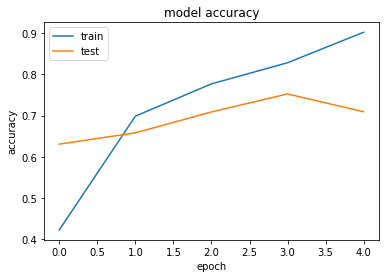

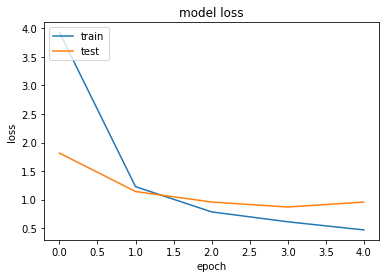

In [82]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()